# Classifying Images with a Deep Neural Network Model

## Learning objectives

* Define Helper Functions.
* Train and evaluate a Neural Network (NN) model.
* Train and evaluate a Deep Neural Network model.

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using a Deep Neural Network Model.

You can refer the companion notebook
[02a_machine_perception.ipynb](https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02a_machine_perception.ipynb) in which much of the data exploration was done.

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the solution for reference.

In [1]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2.6.0


## Defining Helper Functions
#### Reading and Preprocessing image data

In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [3]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2021-11-16 13:49:26.099537: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Train and evaluate a Neural Network (NN) model

One way to get a more complex method is to interpose one or more Dense layers in between the input and output. The model now has three layers. A layer with trainable weights such as the one we added, that is neither the input nor the output, is called a hidden layer.

In Keras, we’d introduce the activation function as below.

The Rectified Linear Unit (ReLU) is the most commonly used activation function for hidden layers – other commonly used activation functions include sigmoid, tanh, and elu.

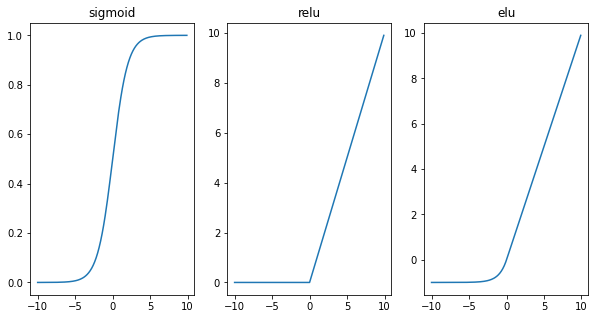

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


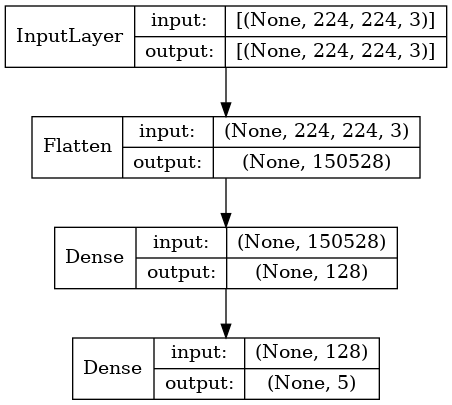

In [5]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [6]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [7]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

2021-11-16 13:49:48.763847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
104/104 [==============================] - 160s 2s/step - loss: 11.0484 - accuracy: 0.3248 - val_loss: 6.8722 - val_accuracy: 0.3324
Epoch 2/10
104/104 [==============================] - 149s 1s/step - loss: 4.2470 - accuracy: 0.3961 - val_loss: 5.3279 - val_accuracy: 0.3378
Epoch 3/10
104/104 [==============================] - 139s 1s/step - loss: 2.7220 - accuracy: 0.4045 - val_loss: 4.0906 - val_accuracy: 0.3892
Epoch 4/10
104/104 [==============================] - 139s 1s/step - loss: 2.2289 - accuracy: 0.4476 - val_loss: 2.8998 - val_accuracy: 0.4054
Epoch 5/10
104/104 [==============================] - 133s 1s/step - loss: 1.8006 - accuracy: 0.4970 - val_loss: 2.1124 - val_accuracy: 0.3676
Epoch 6/10
104/104 [==============================] - 127s 1s/step - loss: 1.3522 - accuracy: 0.5236 - val_loss: 1.4755 - val_accuracy: 0.4324
Epoch 7/10
104/104 [==============================] - 124s 1s/step - loss: 1.5269 - accuracy: 0.4024 - val_loss: 1.5262 - val_accuracy: 0.324

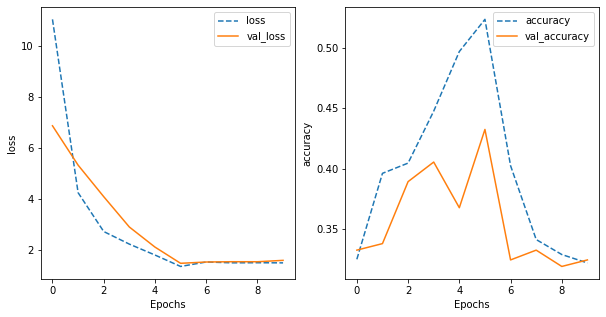

In [8]:
training_plot(['loss', 'accuracy'], history)

## Training the neural network

Training the neural network is similar to training the linear model. We compile the model passing in the optimizer, the loss, and the metrics. Then, we call model.fit() passing in the datasets

In [9]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

First we train our model by using 128 hidden layers.

Epoch 1/10
104/104 [==============================] - 123s 1s/step - loss: 2.3103 - accuracy: 0.3467 - val_loss: 1.4193 - val_accuracy: 0.3973
Epoch 2/10
104/104 [==============================] - 116s 1s/step - loss: 1.3521 - accuracy: 0.4373 - val_loss: 1.3009 - val_accuracy: 0.4595
Epoch 3/10
104/104 [==============================] - 116s 1s/step - loss: 1.2806 - accuracy: 0.4645 - val_loss: 1.2641 - val_accuracy: 0.4541
Epoch 4/10
104/104 [==============================] - 115s 1s/step - loss: 1.2531 - accuracy: 0.4918 - val_loss: 1.2533 - val_accuracy: 0.4595
Epoch 5/10
104/104 [==============================] - 113s 1s/step - loss: 1.2207 - accuracy: 0.5124 - val_loss: 1.2492 - val_accuracy: 0.4730
Epoch 6/10
104/104 [==============================] - 119s 1s/step - loss: 1.1708 - accuracy: 0.5330 - val_loss: 1.2593 - val_accuracy: 0.4514
Epoch 7/10
104/104 [==============================] - 112s 1s/step - loss: 1.1280 - accuracy: 0.5597 - val_loss: 1.3059 - val_accuracy: 0.4595

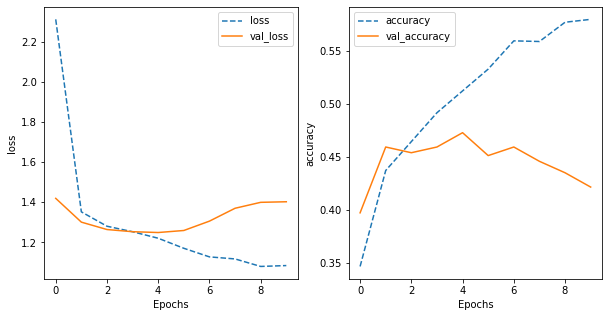

In [10]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

We would normally expect that adding layers to a model will improve the ability of the model to fit the training data, and thus lower the loss. Notice that it is not always the case though.

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 122s 1s/step - loss: 3.0058 - accuracy: 0.3467 - val_loss: 1.5532 - val_accuracy: 0.3973
Epoch 2/10
104/104 [==============================] - 113s 1s/step - loss: 1.4143 - accuracy: 0.4479 - val_loss: 1.3708 - val_accuracy: 0.4595
Epoch 3/10
104/104 [==============================] - 115s 1s/step - loss: 1.3755 - accuracy: 0.4833 - val_loss: 1.3130 - val_accuracy: 0.4784
Epoch 4/10


## Train and evaluate a Deep Neural Network model

Let's train a DNN.
We will parameterize the number of layers, and the
number of nodes in each layer

In [ ]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

In [ ]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])